In [1]:
from skimage.transform import resize
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def iou(box1, box2, thresh = 0.1):
    Irect_xmin, Irect_ymin = max(box1[0],box2[0]), max(box1[2],box2[2])
    Irect_xmax, Irect_ymax = min(box1[1],box2[1]), min(box1[3],box2[3])
    if Irect_xmax < Irect_xmin or Irect_ymax < Irect_ymin:
        target = inter_area = 0
    else: 
        inter_area = np.abs((Irect_xmax - Irect_xmin) * (Irect_ymax - Irect_ymin))
        box1_area = (box1[1]-box1[0])*(box1[3]-box1[2])
        box2_area = (box2[1]-box2[0])*(box2[3]-box2[2])
        union_area = box1_area+box2_area-inter_area
        iou = inter_area/union_area
        target = int(iou > thresh)
    return target

os.chdir(r"\\hd.ad.syr.edu\02\8fe522\Documents\Desktop\BCCD_Dataset-master\BCCD_Dataset-master")

trainCNN = pd.read_csv('test.csv', sep=",", header=None)
trainCNN.columns = ['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']

data = trainCNN
data['cell_type'] = data['cell_type'].replace({'RBC': 0, 'WBC': 1, 'Platelets': 2})






In [2]:
os.chdir(r'\\hd.ad.syr.edu\02\8fe522\Documents\Desktop\BCCD_Dataset-master\BCCD_Dataset-master\BCCD\JPEGImages')
# create empty lists
X = []
Y = []
# set patch co-ordinates
patch_1_coordinates = [0, 320, 0, 240]
patch_2_coordinates = [320, 640, 0, 240]
patch_3_coordinates = [0, 320, 240, 480]
patch_4_coordinates = [320, 640, 240, 480]

files = data.filename.drop_duplicates()

for file in files[1:]:
    # read image
    image = plt.imread(file)
    rbc_coordinates = []
    plat_coordinates = []
    wbc_coordinates = []
    
    for idx, row in data[data.filename == file].iterrows():
        if row.cell_type == 0:
            rbc_coordinates += [[int(row.xmin), int(row.xmax), int(row.ymin), int(row.ymax)]]
        if row.cell_type == 1:
            wbc_coordinates += [[int(row.xmin), int(row.xmax), int(row.ymin), int(row.ymax)]]
        if row.cell_type == 2:
            plat_coordinates += [[int(row.xmin), int(row.xmax), int(row.ymin), int(row.ymax)]]

    # extract patches
    patch_1 = image[patch_1_coordinates[2]:patch_1_coordinates[3],
                             patch_1_coordinates[0]:patch_1_coordinates[1], :]
    patch_2 = image[patch_2_coordinates[2]:patch_2_coordinates[3], 
                               patch_2_coordinates[0]:patch_2_coordinates[1], :]
    patch_3 = image[patch_3_coordinates[2]:patch_3_coordinates[3], 
                            patch_3_coordinates[0]:patch_3_coordinates[1], :]
    patch_4 = image[patch_4_coordinates[2]:patch_4_coordinates[3], 
                            patch_4_coordinates[0]:patch_4_coordinates[1], :]
    
    
   
    
    
    # create final input data
    X.extend([patch_1, patch_2, patch_3, patch_4])
    
    # create target data
    Y.extend([[max([iou(patch_1_coordinates, rbc) for rbc in rbc_coordinates] + [0]),
               max([iou(patch_1_coordinates, wbc) for wbc in wbc_coordinates]+ [0]),
               max([iou(patch_1_coordinates, plat, 0.01) for plat in plat_coordinates]+ [0])], 
              [max([iou(patch_2_coordinates, rbc) for rbc in rbc_coordinates]+ [0]),
               max([iou(patch_2_coordinates, wbc) for wbc in wbc_coordinates]+ [0]),
               max([iou(patch_2_coordinates, plat, 0.01) for plat in plat_coordinates]+ [0])], 
              [max([iou(patch_3_coordinates, rbc) for rbc in rbc_coordinates]+ [0]),
               max([iou(patch_3_coordinates, wbc) for wbc in wbc_coordinates]+ [0]),
               max([iou(patch_3_coordinates, plat, 0.01) for plat in plat_coordinates]+ [0])], 
              [max([iou(patch_4_coordinates, rbc) for rbc in rbc_coordinates]+ [0]),
               max([iou(patch_4_coordinates, wbc) for wbc in wbc_coordinates]+ [0]),
               max([iou(patch_4_coordinates, plat, 0.01) for plat in plat_coordinates]+ [0])]])
    
    
# convert these lists to single numpy array
X = np.array(X)
Y = np.array(Y)
#Y2 = np.moveaxis(Y2, -1, 1)

X = np.moveaxis(X, -1, 1) 
X = X / X.max()

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(X, Y, test_size=0.3)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape




((1019, 3, 240, 320), (437, 3, 240, 320), (1019, 3), (437, 3))

In [5]:
import torch
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)
X_valid = torch.FloatTensor(X_valid)
Y_valid = torch.FloatTensor(Y_valid)



In [43]:
from pytorch_model_summary import summary
from torch import nn
## model architecture
model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2),  
        nn.ReLU(),  
        nn.MaxPool2d(kernel_size=4,stride=2),   
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2),    
        nn.Flatten(),
        nn.Linear(63936  , 3),
        nn.Sigmoid()
)




In [44]:
## loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_plot = []
# batch size of the model
batch_size = 50
# defining the training phase
model.train()
for epoch in range(20):
    # setting initial loss as 0
    train_loss = 0.0        
    # to randomly pick the images without replacement in batches
    permutation = torch.randperm(X_train.size()[0])
    # to keep track of training loss
    training_loss = []
    # for loop for training on batches
    for i in range(0,X_train.size()[0], batch_size):
        # taking the indices from randomly generated values
        indices = permutation[i:i+batch_size]
        # getting the images and labels for a batch
        batch_x, batch_y = X_train[indices], Y_train[indices]
        
        # clearing all the accumulated gradients
        optimizer.zero_grad()
        # mini batch computation
        outputs = model(batch_x)
        # calculating the loss for a mini batch
        loss = criterion(outputs.squeeze(),batch_y)
        # storing the loss for every mini batch
        training_loss.append(loss.item())
        # calculating the gradients
        loss.backward()
        # updating the parameters
        optimizer.step()
    training_loss = np.average(training_loss)
    loss_plot.append(training_loss)
    print('epoch: t', epoch, 't training loss: t', training_loss)

epoch: t 0 t training loss: t 7.240921439159484
epoch: t 1 t training loss: t 0.5113995869954427
epoch: t 2 t training loss: t 0.4444407763935271
epoch: t 3 t training loss: t 0.39491736463138033
epoch: t 4 t training loss: t 0.3910645345846812
epoch: t 5 t training loss: t 0.3802542729037149
epoch: t 6 t training loss: t 0.3735869980993725
epoch: t 7 t training loss: t 0.3598194420337677
epoch: t 8 t training loss: t 0.36013563048271907
epoch: t 9 t training loss: t 0.35561373120262507
epoch: t 10 t training loss: t 0.3539804340828033
epoch: t 11 t training loss: t 0.34457155494462877
epoch: t 12 t training loss: t 0.34717188704581486
epoch: t 13 t training loss: t 0.35159066177549814
epoch: t 14 t training loss: t 0.34191580542496275
epoch: t 15 t training loss: t 0.3353084801208405
epoch: t 16 t training loss: t 0.33424952768144156
epoch: t 17 t training loss: t 0.34186143179734546
epoch: t 18 t training loss: t 0.3353449993190311
epoch: t 19 t training loss: t 0.3429084022839864


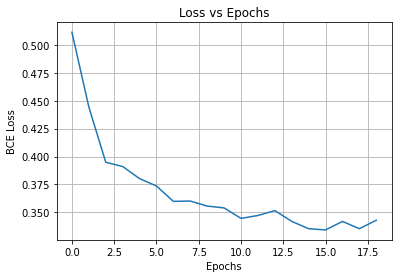

In [68]:
plt.plot(loss_plot[1:])
plt.title('Loss vs Epochs')
plt.ylabel('BCE Loss')
plt.xlabel('Epochs')
plt.grid()

In [45]:
predicts = model(X_valid)

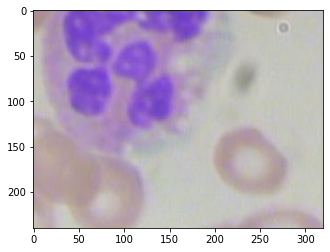

In [46]:
plt.imshow(np.moveaxis(X_valid[1].detach().numpy(), 0, -1))

In [79]:
#get percentage of correct predictions (no rounding)
diff = Y_valid.detach().numpy() - predicts.detach().numpy()
1 -np.mean(np.abs(diff), axis=0)

array([0.8078445, 0.9082971, 0.6940133], dtype=float32)

In [78]:
#get percentage of correct predictions (rounding)
diff2 = Y_valid.detach().numpy() - np.round(predicts.detach().numpy())
1 - np.mean(np.abs(diff2), axis = 0)

array([0.8855835, 0.9359268, 0.7757437], dtype=float32)

In [77]:
#summary
from torchsummary import summary
summary(model, (3,240,320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 118, 158]           4,864
              ReLU-2         [-1, 64, 118, 158]               0
         MaxPool2d-3           [-1, 64, 58, 78]               0
            Conv2d-4           [-1, 64, 27, 37]         102,464
           Flatten-5                [-1, 63936]               0
            Linear-6                    [-1, 3]         191,811
           Sigmoid-7                    [-1, 3]               0
Total params: 299,139
Trainable params: 299,139
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.88
Forward/backward pass size (MB): 21.39
Params size (MB): 1.14
Estimated Total Size (MB): 23.41
----------------------------------------------------------------
